# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.4 encode outliers and major land use types in the Teranet dataset

---

This notebook describes Step 2.4 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.
## Overview
### Mark outliers based on `price_to_med_xy` and `price_to_med_year`
Outliers are market by comparing price with medians for xy coordinate pair and for each year.
### New columns produced from `landuse`
One-hot encoded land use codes for major land uses are added to each Teranet records. In addition, all the values are combined into a single categorical column `landuse_class`. Only major land uses are encoded, the rest are represented by the value `Other`.

### Previous steps included: 

* **Step 2.1:** spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

    * for details, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`

* **Step 2.2:** correction for consistency of the Teranet records

    * column names were converted to lower case
    
    * inconsistent capitalizations were fixed for columns
    
        * `municipality`    
        * `street_name`
        * `street_designation`
        * `postal_code` (did not show problems, converted as a preventive measure)
        
    * columns `province` and `street_suffix` were removed from the dataset
    
    * new column `street_name_raw` was created: reserve copy of unmodified `street_name`
    
    * column `street_name` was parsed and cleaned for:
    
        * `postal_code`
        * `unitno`
        * `street_number`
        * `street_direction`
        * `street_designation`
        
    * plots of the count and percentage of missing values per column were produced
    
    * inconsistent entries were fixed in the following columns:
        
        * `street_direction`
        * `street_designation`
        * `municipality`
        * `street_name`
        * `unitno`
        
    * for details, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for the Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.

For description of Step 2.2 of the cleanup process, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from time import time

sns.set()

In [2]:
import sys

sys.path.append('../../src')

from plot_utils import plot_hist

## Load Teranet data

In [3]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '4_Teranet_lu_encode.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
t = time()

df = pd.read_csv(data_path + '3_Teranet_nonan_new_cols.csv',
                 parse_dates=['registration_date'], low_memory=False)
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 71.82 seconds (1.20 minutes)
with 5,188,513 rows
and 59 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'da_days_since_last_sale',
       'da_years_since_last_sale', 'pin_sale_next_6m', 'pin_sale_next_1y',
       'pin_sale_next_3y', 'xy_sale_next_6m', 'xy_sale_next_1y',
       'xy_sale_next_3y', 'price_2016', 'pin_price_cum_sum',
      

In [5]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5188513 entries, 0 to 5188512
Data columns (total 59 columns):
transaction_id               5188513 non-null int64
lro_num                      5188513 non-null int64
pin                          5188513 non-null int64
consideration_amt            5188513 non-null float64
registration_date            5188513 non-null datetime64[ns]
postal_code                  4881914 non-null object
unitno                       1332616 non-null object
street_name                  5144061 non-null object
street_designation           5090453 non-null object
street_direction             550657 non-null object
municipality                 5187161 non-null object
street_number                5142790 non-null object
x                            5188513 non-null float64
y                            5188513 non-null float64
dauid                        5188513 non-null int64
csduid                       5188513 non-null int64
csdname                      51885

## Mark top outliers based on `price_to_med_xy` and `price_to_med_year`
Outliers with high transaction volumes are marked with a boolean variable `outlier` in the following cases:
* if their value of `price_to_med_year` is greater than 5
* if their value of `price_to_med_xy` is greater that 2.5 (5 standard deviations above the mean)

In [6]:
# set criteria for outliers
mask1 = df['price_to_med_year'] > 5
mask2 = df['price_to_med_xy'] > 2.5

# mark outliers
df.loc[mask1 | mask2, 'outlier'] = True
df['outlier'] = df['outlier'].fillna(False)
print("New column `outlier` was added to the DataFrame.")

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('outlier == True')['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('outlier == False')['price_2016'].mean()))
df['outlier'].value_counts()

New column `outlier` was added to the DataFrame.
Mean price of all records that are marked as outliers: 12,378,169.64
Mean price of all records that are not marked as outliers: 371,660.13


False    5010229
True      178284
Name: outlier, dtype: int64

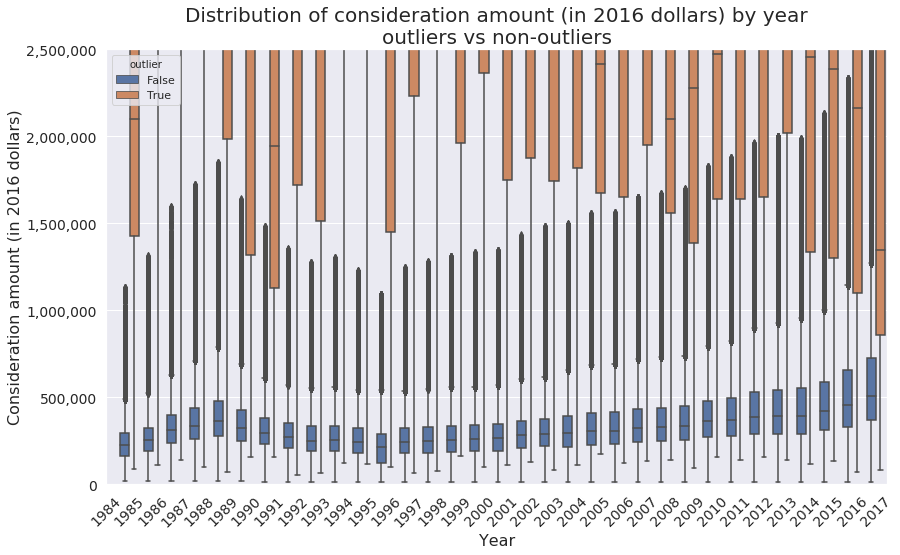

In [7]:
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier', ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 2500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

## Add column `lu_code`: join land use codes for GTA
Hamilton land use codes have been converted to match GTA codes in step 2.1.4.

### Read land use codes for GTA used by geography department

In [8]:
landuse_code_path = data_path + 'ParcelLandUse/GTA/'
os.listdir(landuse_code_path)

['GTA_land_use_code.txt',
 'GTAparcel16LU12.shx',
 'with_epoi',
 'GTAparcel16LU12.prj',
 'gta_land_use_code.csv',
 'GTAparcel16LU12.cpg',
 'GTAparcel16LU12.shp',
 'GTAparcel16LU12.dbf']

In [9]:
land_use_codes = pd.read_csv(landuse_code_path + 'gta_land_use_code.csv')
land_use_codes.head()

,landuse,code
0,0,Uncoded
1,1,Single Detached House
2,2,Commercial/Shopping
3,3,Industrial/Employment Lands
4,4,Government/Institutional


### Join land use codes to Teranet records

In [10]:
# join GTA land use codes
df = pd.merge(df, land_use_codes, how='left',
              left_on='landuse', right_on='landuse')
print("GTA land use codes were joined to the DataFrame.")
df['code'].value_counts().head(10)

GTA land use codes were joined to the DataFrame.


Single Detached House                          2189784
Apartments/Condos/Residence                    1102936
Strata Townhouses                               313918
Duplex/Semi-Detached                            244329
Townhouse                                       178585
Mix(Commercial Residential)                     167410
Underdeveloped Land                             153307
Mixed Complex (Residential, Office, Retail)     112398
Industrial/Employment Lands                     106056
Commercial/Shopping                             102172
Name: code, dtype: int64

## One-hot encode top 10 land uses by frequency
Top 10 land uses by count of Teranet records are one-hot (binary) encoded into separate variables.

### Single Detached House
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

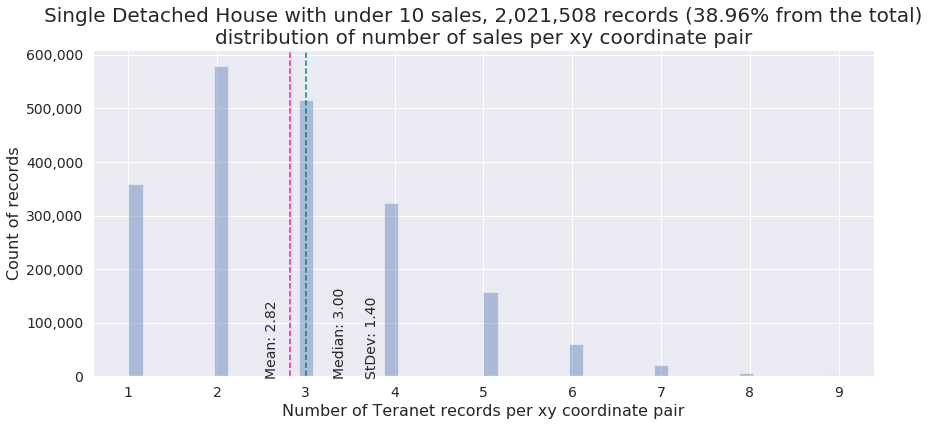

In [11]:
lu_type = 'Single Detached House'
max_sales = 10
mask1 = df['code'] == lu_type
mask2 = df['xy_total_sales'] < max_sales
mask3 = df['outlier'] == False
s = df[mask1 & mask2 & mask3]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=0.9, med_xlift=1.1, sdev_xlift=1.3)

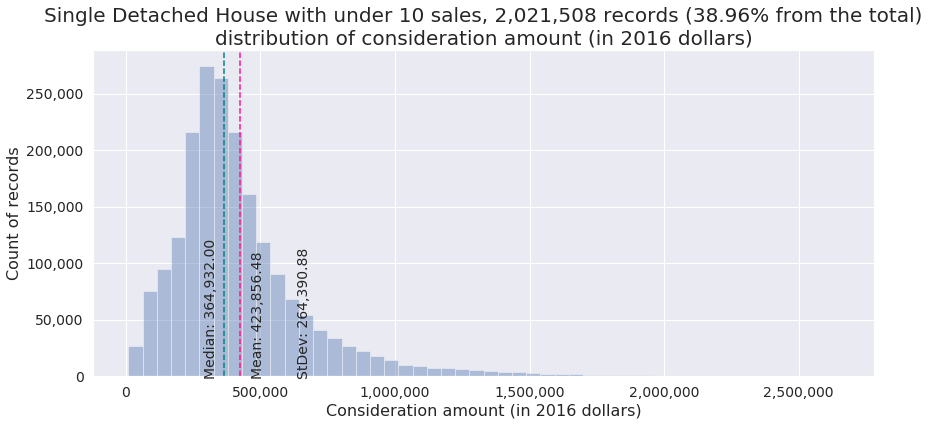

In [12]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=1.1, med_xlift=0.8, sdev_xlift=1.5)

#### Add new binary variable and new class to `lu_class`

In [13]:
df.loc[mask1 & mask2 & mask3, 'lu_class'] = lu_type
df.loc[mask1 & mask2 & mask3, 'luc_detached'] = True
df['luc_detached'] = df['luc_detached'].fillna(False)
df['luc_detached'].value_counts()

False    3167005
True     2021508
Name: luc_detached, dtype: int64

### Apartments/condos/residence
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

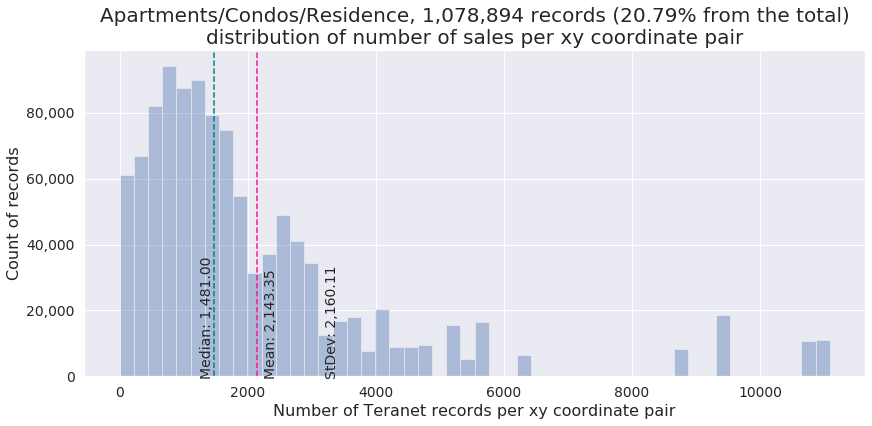

In [14]:
lu_type = 'Apartments/Condos/Residence'
mask1 = df['code'] == lu_type
mask2 = df['outlier'] == False
s = df[mask1 & mask2]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
                "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", mean_xlift=1.05, med_xlift=0.85, sdev_xlift=1.5)

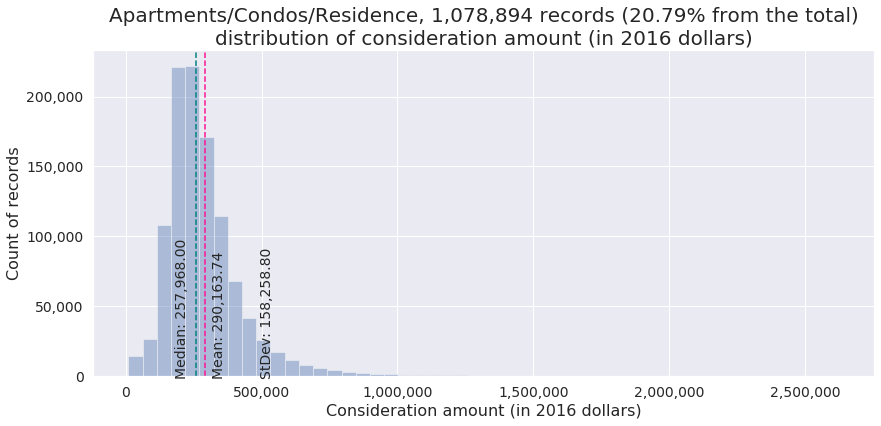

In [15]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
                "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", mean_xlift=1.1, med_xlift=0.7, sdev_xlift=1.7)

#### Add new binary variable and new class to `lu_class`

In [16]:
df.loc[mask1 & mask2, 'lu_class'] = lu_type
df.loc[mask1 & mask2, 'luc_condo'] = True
df['luc_condo'] = df['luc_condo'].fillna(False)
df['luc_condo'].value_counts()

False    4109619
True     1078894
Name: luc_condo, dtype: int64

### Strata Townhouses
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

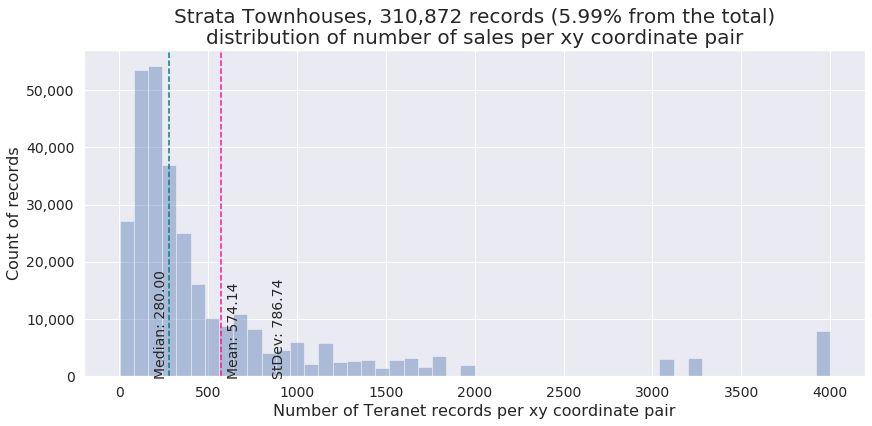

In [17]:
lu_type = 'Strata Townhouses'
mask1 = df['code'] == lu_type
mask2 = df['outlier'] == False
s = df[mask1 & mask2]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
                "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", mean_xlift=1.05, med_xlift=0.7, sdev_xlift=1.5)

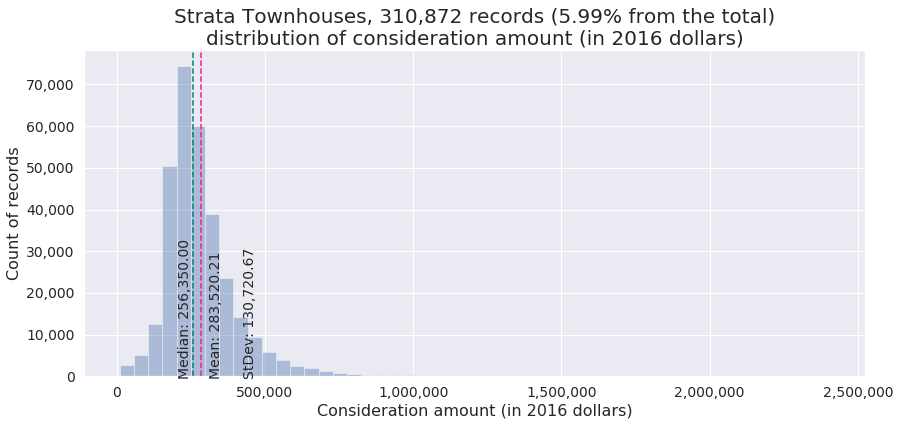

In [18]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", mean_xlift=1.1, med_xlift=0.8, sdev_xlift=1.5)

#### Add new binary variable and new class to `lu_class`

In [19]:
df.loc[mask1 & mask2, 'lu_class'] = lu_type
df.loc[mask1 & mask2, 'luc_strata'] = True
df['luc_strata'] = df['luc_strata'].fillna(False)
df['luc_strata'].value_counts()

False    4877641
True      310872
Name: luc_strata, dtype: int64

### Duplex/Semi-Detached
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

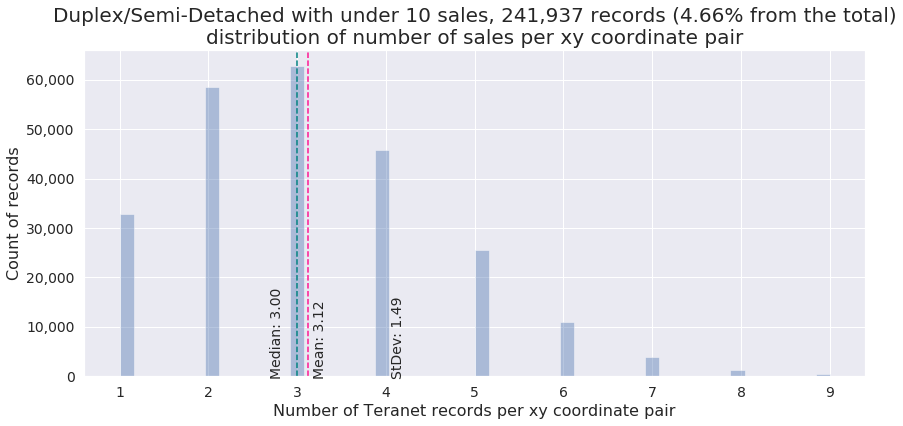

In [20]:
lu_type = 'Duplex/Semi-Detached'
max_sales = 10
mask1 = df['code'] == lu_type
mask2 = df['xy_total_sales'] < max_sales
mask3 = df['outlier'] == False
s = df[mask1 & mask2 & mask3]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3)

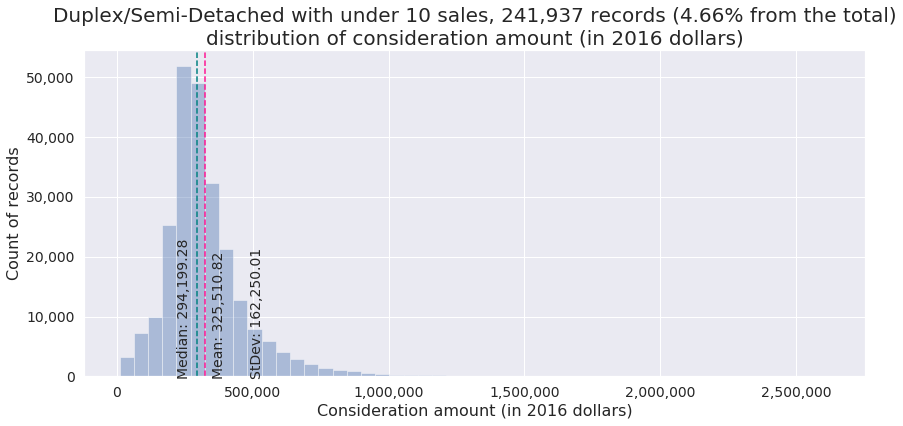

In [21]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=1.07, med_xlift=0.75, sdev_xlift=1.5)

#### Add new binary variable and new class to `lu_class`

In [22]:
df.loc[mask1 & mask2 & mask3, 'lu_class'] = lu_type
df.loc[mask1 & mask2 & mask3, 'luc_duplex'] = True
df['luc_duplex'] = df['luc_duplex'].fillna(False)
df['luc_duplex'].value_counts()

False    4946576
True      241937
Name: luc_duplex, dtype: int64

### Townhouse
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

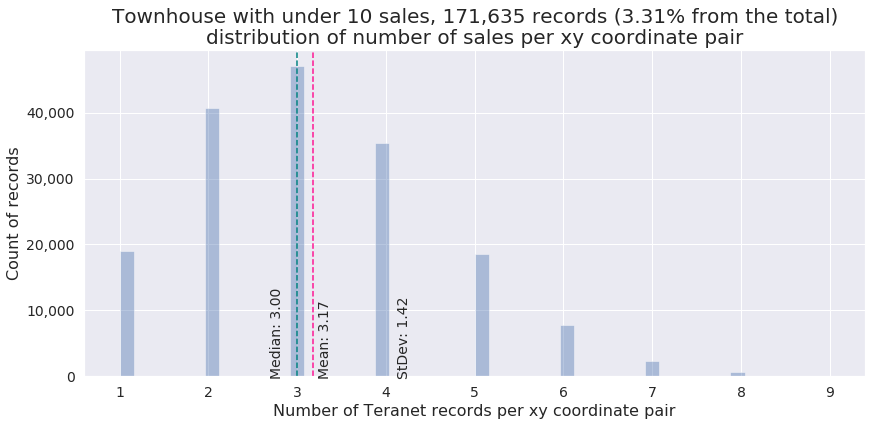

In [23]:
lu_type = 'Townhouse'
max_sales = 10
mask1 = df['code'] == lu_type
mask2 = df['xy_total_sales'] < max_sales
mask3 = df['outlier'] == False
s = df[mask1 & mask2 & mask3]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3)

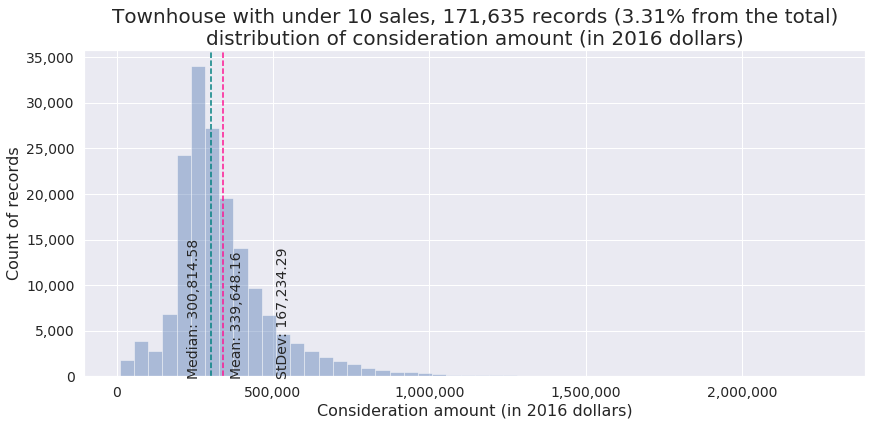

In [24]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=1.07, med_xlift=0.75, sdev_xlift=1.5)

#### Add new binary variable and new class to `lu_class`

In [25]:
df.loc[mask1 & mask2 & mask3, 'lu_class'] = lu_type
df.loc[mask1 & mask2 & mask3, 'luc_townhouse'] = True
df['luc_townhouse'] = df['luc_townhouse'].fillna(False)
df['luc_townhouse'].value_counts()

False    5016878
True      171635
Name: luc_townhouse, dtype: int64

### Mix(Commercial Residential)
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

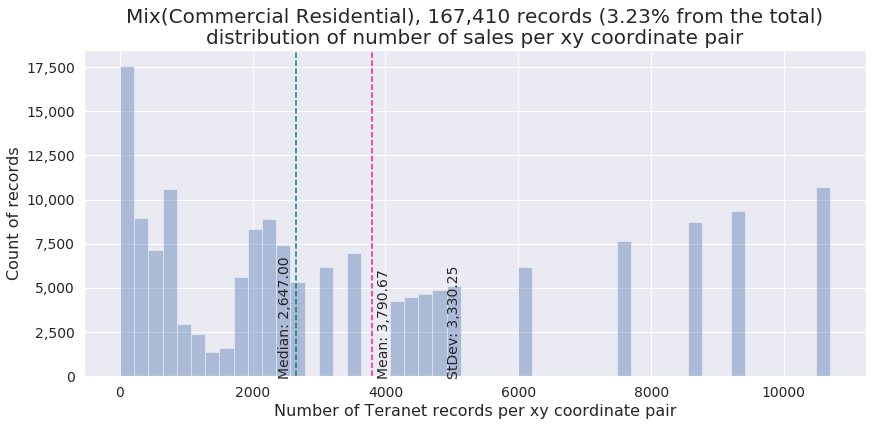

In [26]:
lu_type = 'Mix(Commercial Residential)'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3)

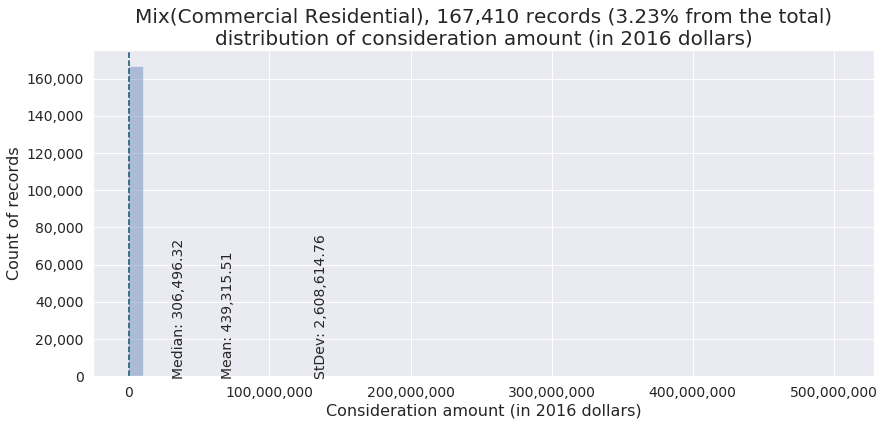

In [27]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=150, med_xlift=100, sdev_xlift=300)

#### Add new binary variable and new class to `lu_class`

In [28]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_mixuse'] = True
df['luc_mixuse'] = df['luc_mixuse'].fillna(False)
df['luc_mixuse'].value_counts()

False    5021103
True      167410
Name: luc_mixuse, dtype: int64

### Underdeveloped Land
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

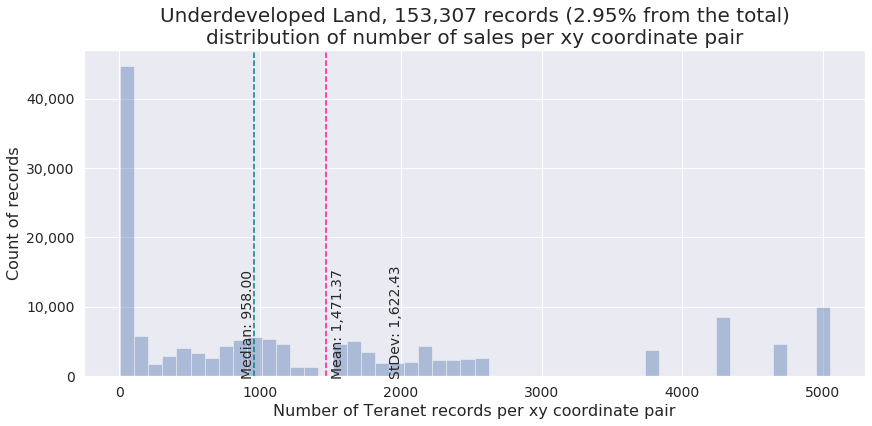

In [29]:
lu_type = 'Underdeveloped Land'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3)

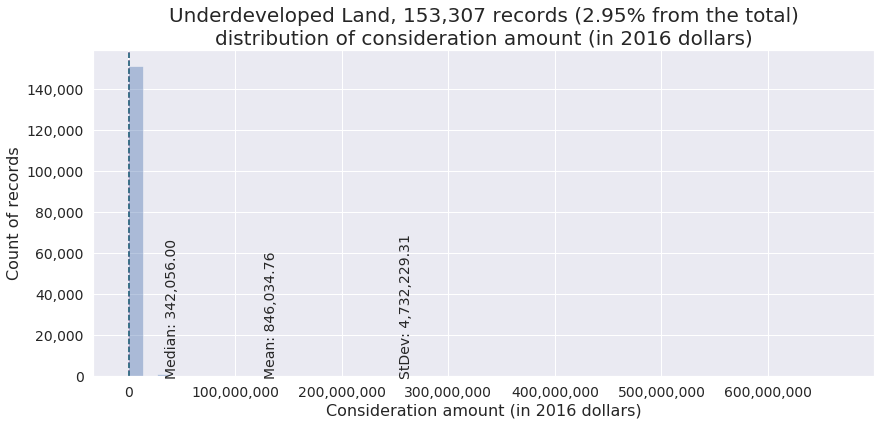

In [30]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=150, med_xlift=100, sdev_xlift=300)

#### Add new binary variable and new class to `lu_class`

In [31]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_underdeveloped'] = True
df['luc_underdeveloped'] = df['luc_underdeveloped'].fillna(False)
df['luc_underdeveloped'].value_counts()

False    5035206
True      153307
Name: luc_underdeveloped, dtype: int64

### Mixed Complex (Residential, Office, Retail)
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

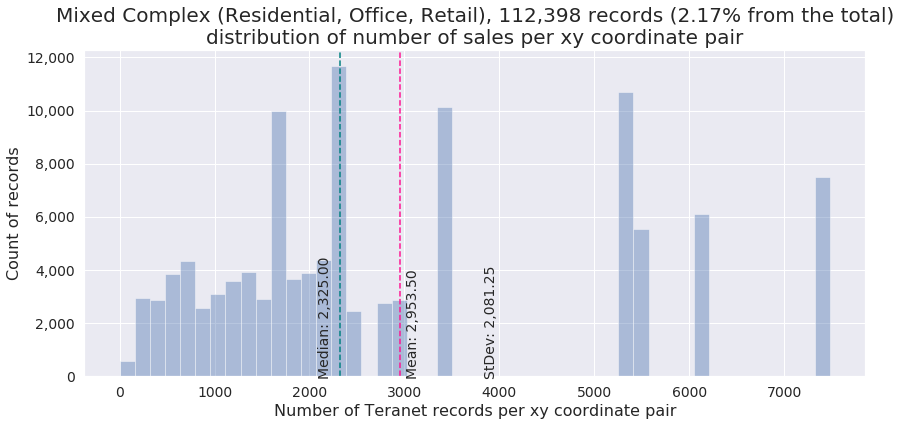

In [32]:
lu_type = 'Mixed Complex (Residential, Office, Retail)'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3)

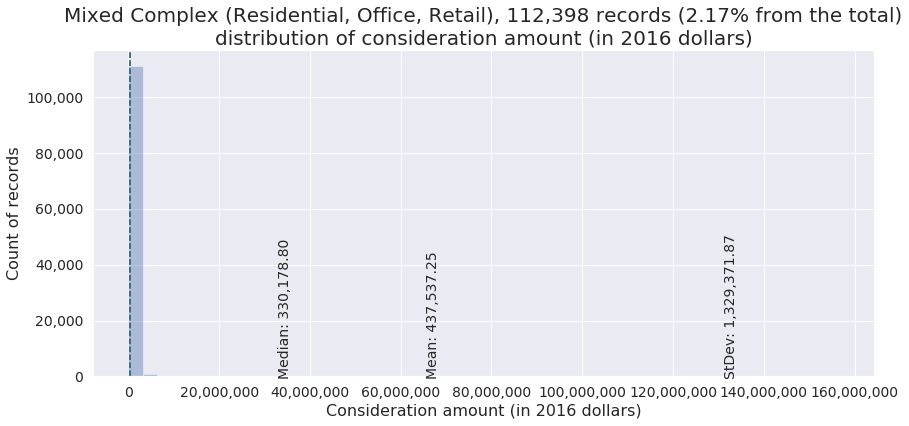

In [33]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=150, med_xlift=100, sdev_xlift=300)

#### Add new binary variable and new class to `lu_class`

In [34]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_mixedcomplex'] = True
df['luc_mixedcomplex'] = df['luc_mixedcomplex'].fillna(False)
df['luc_mixedcomplex'].value_counts()

False    5076115
True      112398
Name: luc_mixedcomplex, dtype: int64

### Industrial/Employment Lands
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

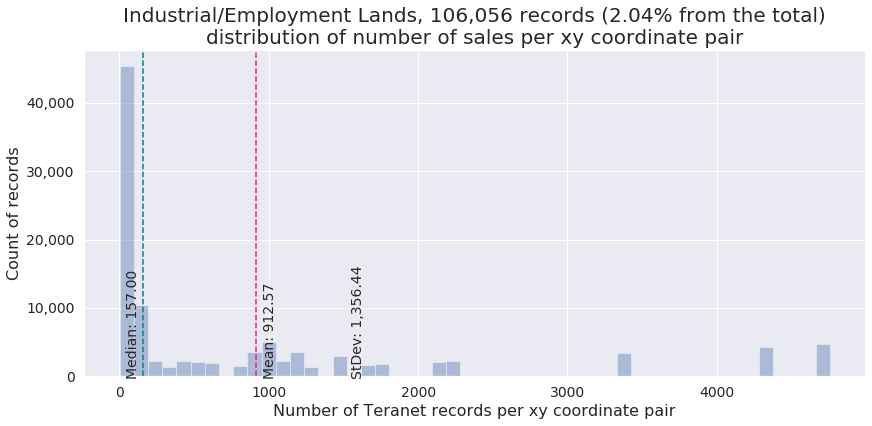

In [35]:
lu_type = 'Industrial/Employment Lands'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.05, med_xlift=0.3, sdev_xlift=1.7)

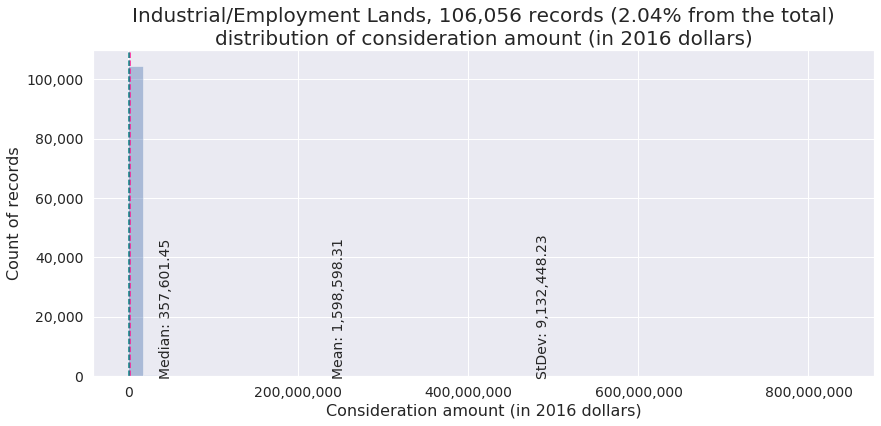

In [36]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=150, med_xlift=100, sdev_xlift=300)

#### Add new binary variable and new class to `lu_class`

In [37]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_industrial'] = True
df['luc_industrial'] = df['luc_industrial'].fillna(False)
df['luc_industrial'].value_counts()

False    5082457
True      106056
Name: luc_industrial, dtype: int64

### Commercial/Shopping
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

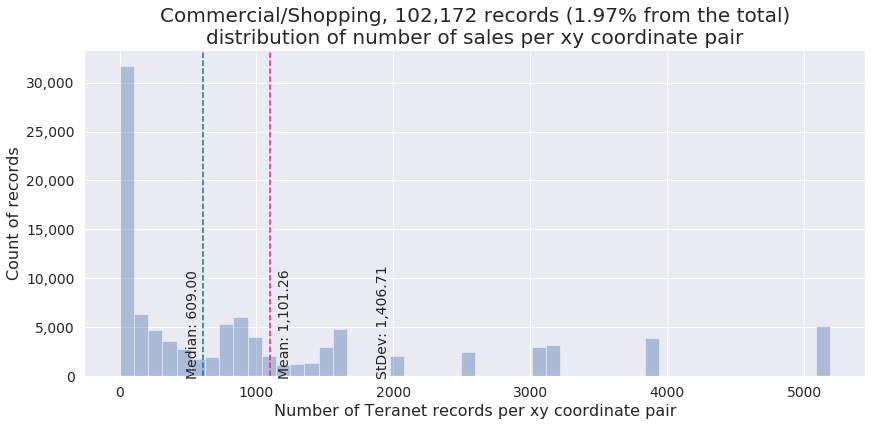

In [38]:
lu_type = 'Commercial/Shopping'
mask1 = df['code'] == lu_type

s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.05, med_xlift=0.8, sdev_xlift=1.7)

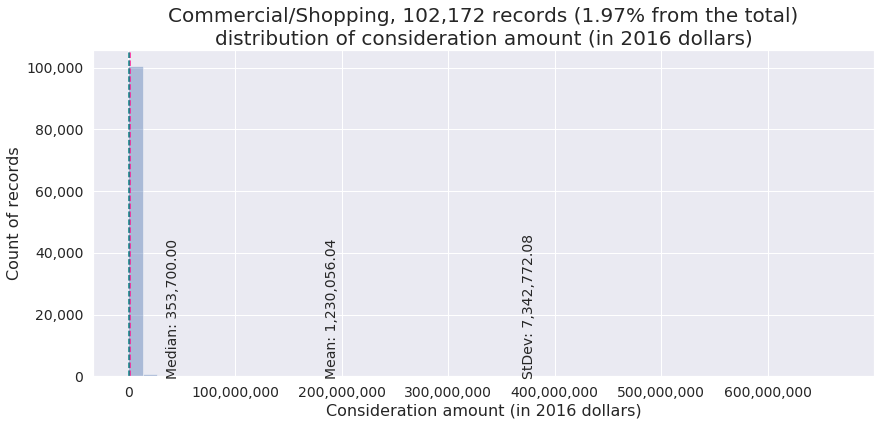

In [39]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=150, med_xlift=100, sdev_xlift=300)

#### Add new binary variable and new class to `lu_class`

In [40]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_commercial'] = True
df['luc_commercial'] = df['luc_commercial'].fillna(False)
df['luc_commercial'].value_counts()

False    5086341
True      102172
Name: luc_commercial, dtype: int64

#### Validate number of records

In [41]:
df['luc_detached'].sum() + df['luc_condo'].sum() + df['luc_strata'].sum() + \
    df['luc_duplex'].sum() + df['luc_townhouse'].sum() + df['luc_mixuse'].sum() + \
    df['luc_mixedcomplex'].sum() + df['luc_industrial'].sum() + df['luc_commercial'].sum()

4312882

In [42]:
df['lu_class'].value_counts().sum()

4466189

In [43]:
df['lu_class'].value_counts()

Single Detached House                          2021508
Apartments/Condos/Residence                    1078894
Strata Townhouses                               310872
Duplex/Semi-Detached                            241937
Townhouse                                       171635
Mix(Commercial Residential)                     167410
Underdeveloped Land                             153307
Mixed Complex (Residential, Office, Retail)     112398
Industrial/Employment Lands                     106056
Commercial/Shopping                             102172
Name: lu_class, dtype: int64

## Encode land use into 3 classes: house, condo and other
Land use classes produced above will be reduced to a 3 class case:
1. Houses (single detached, duplex/semi-detached, townhouses)
2. Condos (apartments/condos, strata townhouses)
3. Everything else (mix use, commercial, industrial, etc.)

New classes will be encoded one-hot and as a single categorical variable.
### Distributions of price

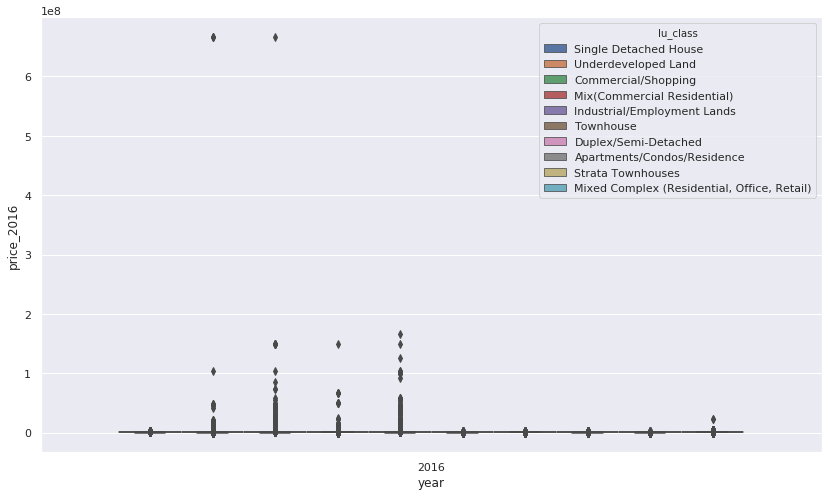

In [44]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='price_2016', hue='lu_class', ax=ax)
plt.show()

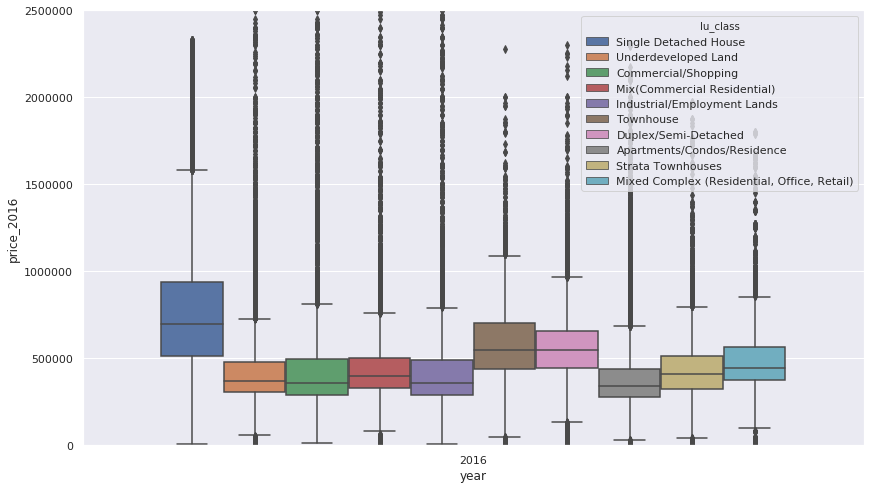

In [45]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='price_2016', hue='lu_class', ax=ax)
ax.set_ylim(0, 2500000)
plt.show()

### Distribtutions of total sales per xy coordinate pair

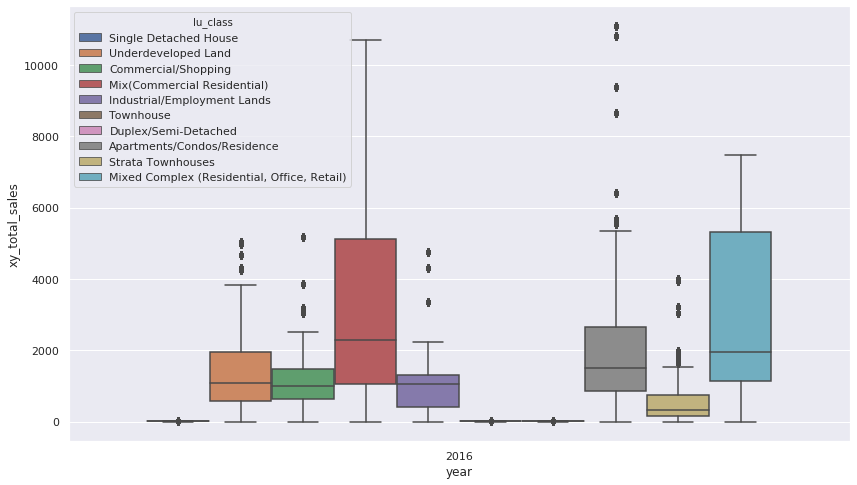

In [46]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='xy_total_sales', hue='lu_class', ax=ax)
plt.show()

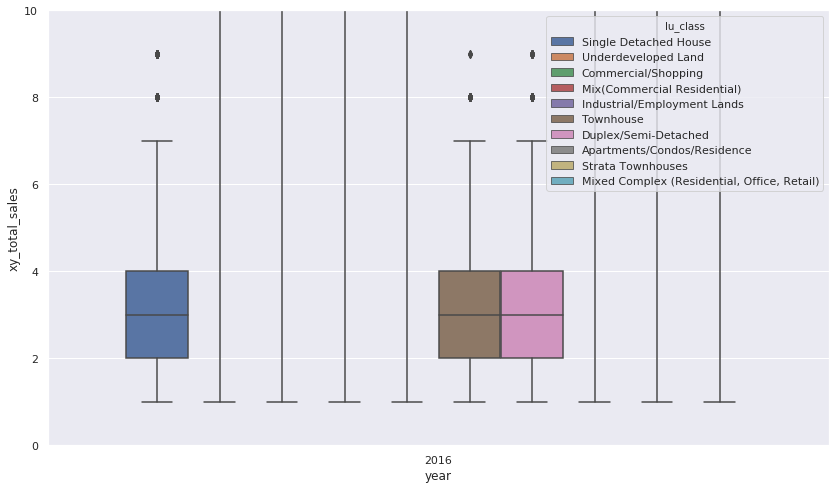

In [47]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='xy_total_sales', hue='lu_class', ax=ax)
ax.set_ylim(0, 10)
plt.show()

### Encode variables into 3 categories

#### Category "house": detached, semi-detached and townhouses

In [48]:
cat_list = ['Single Detached House', 'Duplex/Semi-Detached', 'Townhouse']
mask1 = df['lu_class'].isin(cat_list)
df.loc[mask1, 'lucr_house'] = True
df.loc[mask1, 'lucr'] = 'house'
df['lucr_house'] = df['lucr_house'].fillna(False)
df['lucr_house'].value_counts()

False    2753433
True     2435080
Name: lucr_house, dtype: int64

#### Category "condo": apartments/condos and strata townhouses

In [49]:
cat_list = ['Apartments/Condos/Residence', 'Strata Townhouses']
mask1 = df['lu_class'].isin(cat_list)
df.loc[mask1, 'lucr_condo'] = True
df.loc[mask1, 'lucr'] = 'condo'
df['lucr_condo'] = df['lucr_condo'].fillna(False)
df['lucr_condo'].value_counts()

False    3798747
True     1389766
Name: lucr_condo, dtype: int64

#### Category "other": mixed, commercial, industrial and all other development types

In [50]:
mask1 = df['lucr_house'] == False
mask2 = df['lucr_condo'] == False
df.loc[mask1 & mask2, 'lucr_other'] = True
df.loc[mask1 & mask2, 'lucr'] = 'other'
df['lucr_other'] = df['lucr_other'].fillna(False)
df['lucr_other'].value_counts()

False    3824846
True     1363667
Name: lucr_other, dtype: int64

#### Count of Teranet records by reduced land use category

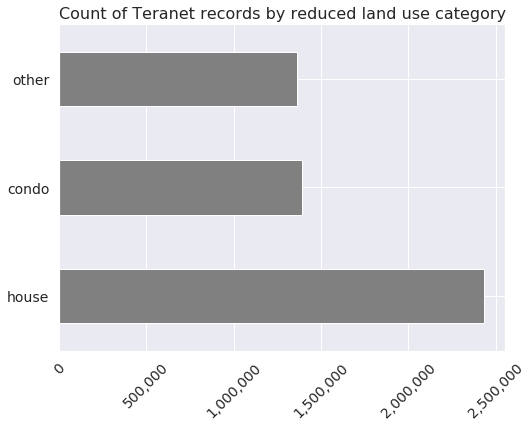

In [51]:
f, ax = plt.subplots(1, figsize=(8, 6))
df['lucr'].value_counts().plot(kind='barh', ax=ax, color='gray')
ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Count of Teranet records by reduced land use category", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## Save results to a new .csv file
Teranet dataset without NaN records and with new columns is saved as:
`data/HHSaleHistory_cleaned_v0.9_GTHA_DA_with_cols_v0.9.csv`

In [52]:
df.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'da_days_since_last_sale',
       'da_years_since_last_sale', 'pin_sale_next_6m', 'pin_sale_next_1y',
       'pin_sale_next_3y', 'xy_sale_next_6m', 'xy_sale_next_1y',
       'xy_sale_next_3y', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'med_price

In [53]:
save_path = data_path + '4_Teranet_lu_encode.csv'
t = time()
df.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds ({1:.2f} minutes).".format(elapsed, elapsed / 60))

DataFrame saved to file:
 ../../data/teranet/4_Teranet_lu_encode.csv 
took 491.77 seconds (8.20 minutes).
